The goal of this notebook is to do exploratory analysis on whether different chord progressions appear at different rates in different genres.

In [2]:
# importing basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import copy
from collections import Counter, deque

# read in the data set
df = pd.read_csv('../data/chordonomicon.csv', low_memory=False)

In [3]:
# Read the mapping CSV file
chord_relations = pd.read_csv('../data/chords_mapping.csv')

# Create a dictionary with keys the "chords" and values the "degrees"
chord_degrees = dict(zip(chord_relations['Chords'], chord_relations['Degrees']))
for key, value in chord_degrees.items():
    chord_degrees[key] = ast.literal_eval(value)
    
# full list of chords from the chords_mapping csv
known_chords = list(chord_degrees.keys())

In [4]:
# drop all columns except for chords and genres
chord_data = df[['chords','genres']]

# drop anything that lacks chord or genre data
chord_data = chord_data.dropna()

The next few blocks clean up the data: replacing spaces with commas in the chords, removing section markers from chord strings, removing inversions from chord strings, and simplifying the genres.

In [6]:
# replacing spaces with commas
def replace_space_with_comma(my_string):
    return my_string.replace(" ",",")

# Remove section markers
def remove_section_markers(my_string):
    result = []
    i = 0
    n = len(my_string)
    while i < n:
        if my_string[i] == '<':
            # Skip until after the following ", "
            j = my_string.find('>', i)
            if j == -1:
                break  # no closing '>', stop
            i = j + 2  # skip '>,' and the space
        else:
            result.append(my_string[i])
            i += 1
    assert('<' not in result)
    assert('>' not in result)
    return ''.join(result)

# Remove inversions
def remove_inversions(my_string):
    result = []
    i = 0
    n = len(my_string)
    while i < n:
        if my_string[i] == '/':
            # Skip until after the following ", "
            j = my_string.find(',', i)
            if j == -1:
                break  # no closing comma, stop
            i = j  # skip comma
        else:
            result.append(my_string[i])
            i += 1
    return ''.join(result)

def clean_up_chord_string(my_string):
    return remove_inversions(
        remove_section_markers(
            replace_space_with_comma(my_string)))

# replacing spaces with commons in all chords in all rows of the data
chord_data.loc[:,'chords'] = chord_data['chords'].apply(clean_up_chord_string)

In [7]:
# simplify genre data
major_genres = ['pop','rock','country','alternative','punk','metal','rap','soul','jazz','reggae','electronic']
def simplify_genre(genre_string):
    for g in major_genres:
        if g in genre_string:
            return g
    return 'other'

chord_data.loc[:,'genres'] = chord_data['genres'].apply(simplify_genre)
major_genres.append('other')

In [8]:
genre_counter = Counter(chord_data.genres)
genre_counter

Counter({'pop': 131247,
         'other': 106961,
         'rock': 81276,
         'country': 15884,
         'punk': 10060,
         'alternative': 4358,
         'rap': 4013,
         'metal': 3007,
         'soul': 2909,
         'reggae': 2156,
         'jazz': 1857,
         'electronic': 545})

In [9]:
# sort genres by frequency in the total database
major_genres = [t[0] for t in genre_counter.most_common()]
major_genres

['pop',
 'other',
 'rock',
 'country',
 'punk',
 'alternative',
 'rap',
 'metal',
 'soul',
 'reggae',
 'jazz',
 'electronic']

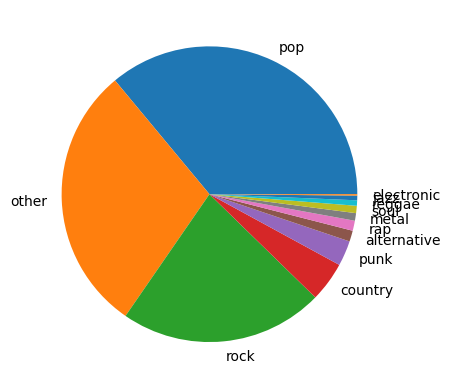

In [10]:
# Pie chart of genres in the whole data set
plt.pie(x = [t[1] for t in genre_counter.most_common()], 
        labels = [t[0] for t in genre_counter.most_common()])
plt.show()

In [11]:
# method to transpose a chord in vector format
def transpose_chord_up(chord_vector, num_semitones):
    d = deque(chord_vector)
    d.rotate(num_semitones)
    return(list(d))
    
# method to return true if chord_1 and chord_2 are just tranposed versions of each other
def is_harmonic_equivalent(chord_1, chord_2):
    # if they have different numbers of notes, then we don't have to check if 
    # any of the transpositions are equal
    if sum(chord_1) != sum(chord_2):
        return False

    # if they have the same number of notes, just rotate through the 12 possible transpositions to check
    for i in range(12):
        if np.array_equal(chord_1, transpose_chord_up(chord_2, i)):
            return True

    return False

C = chord_degrees['C']
D = chord_degrees['D']
E = chord_degrees['E']
G = chord_degrees['G']
assert(is_harmonic_equivalent(C,D))
assert(is_harmonic_equivalent(C,E))
assert(is_harmonic_equivalent(D,E))
assert(is_harmonic_equivalent(C,G))

Cmaj7 = chord_degrees['Cmaj7']
Dmaj7 = chord_degrees['Dmaj7']
assert(is_harmonic_equivalent(Cmaj7,Dmaj7))

In [12]:
# function to convert a string of comma-separated chords into a matrix, where each row denotes a chord
def string_to_chord_matrix(chord_sequence):
    # split sequence over commas, ignoring any "empty string" chords
    chord_list = [c for c in chord_sequence.split(',') if c != '']
    
    # then look up each chord in chord_degrees dictionary by the key value
    return np.array([chord_degrees[c] for c in chord_list])

def transpose_matrix_up(chord_matrix, num_semitones):
    # transpose the entire matrix up by a number of semitones
    # this just means applying transpose_chord_up to each row
    return np.array([transpose_chord_up(row,num_semitones) for row in chord_matrix])

def is_harmonic_equivalent_matrix(chord_matrix_1, chord_matrix_2):
    # return true if chord_matrix_1 and chord_matrix_2 are just tranposed versions of each other

    # some basic checks to skip some looping when we can rule that out already
    if chord_matrix_1.shape != chord_matrix_2.shape:
        return False
    
    for i in range(len(chord_matrix_1)):
        if chord_matrix_1[i].sum() != chord_matrix_2[i].sum():
            return False

    # loop to check if they're the same
    for i in range(12):
        if np.array_equal(chord_matrix_1, transpose_matrix_up(chord_matrix_2, i)):
            return True

    return False

CD = string_to_chord_matrix('C,D')
DE = string_to_chord_matrix('D,E')
assert(is_harmonic_equivalent_matrix(CD,DE))

In [13]:
# return true/false depending on if a song contains a literal/raw equivalent n_gram to the input n_gram
def contains_raw_n_gram(song, n_gram):
    # assumption: input song is a comma-separated string of chord names
    # assumption: input n_gram is a comma-separated string of chord names
    return (n_gram in song)

assert(contains_raw_n_gram('A,B,C,D,Emin','B,C,D'))

# return true/false depending on if a song contains a harmonically equivalent n_gram to the input n_gram
def contains_n_gram(song, n_gram):
    # assumption: input song is a comma-separated string of chord names
    # assumption: input n_gram is a comma-separated string of chord names

    # skip ahead and return true if the raw version is the song
    if n_gram in song:
        return True
    
    song_as_matrix = string_to_chord_matrix(song)
    n_gram_as_matrix = string_to_chord_matrix(n_gram)
    song_length = len(song_as_matrix)
    n = len(n_gram_as_matrix)
    for i in range(song_length - n + 1):
        if is_harmonic_equivalent_matrix(n_gram_as_matrix, song_as_matrix[i:i+n]):
            return True
    return False

assert(contains_n_gram('A,B,C,D,Emin','B,C,D'))
assert(contains_n_gram('C,G,C,F,G','C,G,C'))
assert(contains_n_gram('C,G,C,F,G','D,A,D'))
assert(contains_n_gram('C,G,C,F,G','E,B,E'))

In [14]:
# example of how to add a one-hot encoding column for whether songs contain a given n-gram, up to harmonic equivalent
song_df = copy.deepcopy(chord_data.sample(10))
raw_chord = 'G,C' # representative concrete example of an n-gram
harmonic_function = '51' # new column title
song_df.insert(loc=len(song_df.columns),
               column = harmonic_function,
               value = song_df['chords'].apply(lambda song : int(contains_n_gram(song, raw_chord))))
song_df

,chords,genres,51
340202,"F,Dmin,F,Dmin,Bb,C,Amin,Dmin,Amin,Gmin,C,F,Dmi...",rock,1
425769,"Emin,G,C,D,Emin,G,C,D,Emin,C,Emin,C,D,Bmin,C,D...",rock,1
140367,"Csmin7,Csmin13,Csmin7,Csmin13,Csmin7,Csmin13,C...",pop,0
454119,"C,C,Emin,F,Fmin,C,F,Fmin,C,C,Amin,G,F,Gs,C,F,C...",rock,1
520661,"A,D,Emin,A,D,Emin,A,D,Emin,A,D,Emin,A,D,Emin,A...",other,1
374803,"C,Bb,C,Dmin,G,C,F,Dmin,D,C,G,C,Dmin,C,D,C,D,Em...",rock,1
259845,"G,C9,G,C9,Emin7,G,C9,Emin7,G,C9,Emin7,G,C9,Emi...",rock,1
67696,"G,Emin,Amin,C,G,Emin,Amin,C,G,Emin,Amin,C,G,Em...",pop,1
232050,"Eno3d,Cno3d,G,Dno3d,Eno3d,Cno3d,G,Dno3d,Eno3d,...",rock,0
351459,"G,C,D,G,C,D,G,C,D,G,C,D,D,G,D,G,C,D,D,G,D,G,C,...",country,1


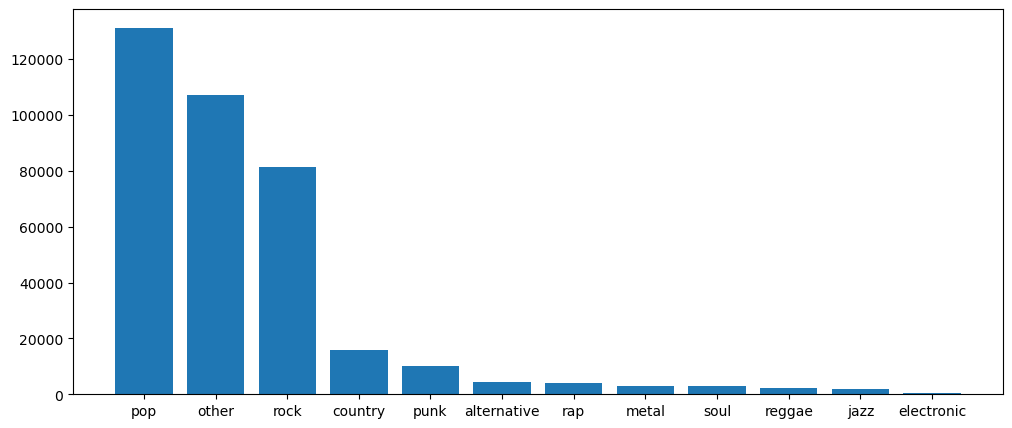

In [15]:
baseline_genre_counter = Counter(chord_data.genres)
baseline_genres, baseline_values = zip(*baseline_genre_counter.most_common())
plt.figure(figsize=(12,5))
plt.bar(x = baseline_genres, 
        height = baseline_values)
plt.show()

In [16]:
# For a given n-gram, make a bar chart of genre distribution
def genre_bars(data, n_gram, column_name):
    # Given an input n-gram (in comma-separated string format),
    # find the songs that contain that n-gram,
    # then make a pie chart of the genres of those songs

    # make a deep copy of the data
    df = copy.deepcopy(data)
    
    # add a one-hot binary encoded column for containing the n-gram
    df[column_name] = df['chords'].apply(lambda song : int(contains_n_gram(song, n_gram)))
    
    # ake a filtered dataframe, containing only songs with the given n-gram
    filtered_df = df[df[column_name] == 1]

    # build some counter objects, and lists of values for bar chart making
    filtered_genre_counter = Counter(filtered_df.genres) # the counter for songs containing the fixed n_gram
    baseline_genre_counter = Counter(chord_data.genres)
    values_filtered = [filtered_genre_counter.get(g,0) for g in major_genres]
    values_baseline = [baseline_genre_counter.get(g,0) for g in major_genres]

    # normalize the data   
    total_filtered = sum(values_filtered)
    total_baseline = sum(values_baseline)
    normalized_values_filtered = [v / total_filtered for v in values_filtered]
    normalized_values_baseline = [v / total_baseline for v in values_baseline]

    x = np.arange(len(major_genres))
    w = 0.4
    plt.figure(figsize = (22, 5))
    plt.bar(x = x - w/2,
            height = normalized_values_filtered,
            width = w,
            label = 'Songs containing ' + n_gram)
    plt.bar(x = x + w/2,
            height = normalized_values_baseline,
            width = w,
            label = 'All songs')
    plt.xticks(x, major_genres, rotation = 45, ha = 'right')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [17]:
# For a given n-gram, make a bar chart of deviations from baseline genre distribution
def deviation_bars(data, n_gram, column_name):
    # Given an input n-gram (in comma-separated string format),
    # find the songs that contain that n-gram,
    # then make a pie chart of the genres of those songs

    # make a deep copy of the data
    df = copy.deepcopy(data)
    
    # add a one-hot binary encoded column for containing the n-gram
    df[column_name] = df['chords'].apply(lambda song : int(contains_n_gram(song, n_gram)))
    
    # ake a filtered dataframe, containing only songs with the given n-gram
    filtered_df = df[df[column_name] == 1]

    # build some counter objects, and lists of values for bar chart making
    filtered_genre_counter = Counter(filtered_df.genres) # the counter for songs containing the fixed n_gram
    baseline_genre_counter = Counter(chord_data.genres)
    values_filtered = [filtered_genre_counter.get(g,0) for g in major_genres]
    values_baseline = [baseline_genre_counter.get(g,0) for g in major_genres]

    # normalize the data   
    total_filtered = sum(values_filtered)
    total_baseline = sum(values_baseline)
    normalized_values_filtered = [v / total_filtered for v in values_filtered]
    normalized_values_baseline = [v / total_baseline for v in values_baseline]
    deviations = list(np.array(normalized_values_filtered) - np.array(normalized_values_baseline))

    x = np.arange(len(major_genres))
    plt.figure(figsize = (22, 5))
    plt.bar(x = x,
            height = deviations)
    plt.xticks(x, major_genres, rotation = 45, ha = 'right')
    plt.ylim(-0.5,0.5)
    plt.tight_layout()
    plt.show()

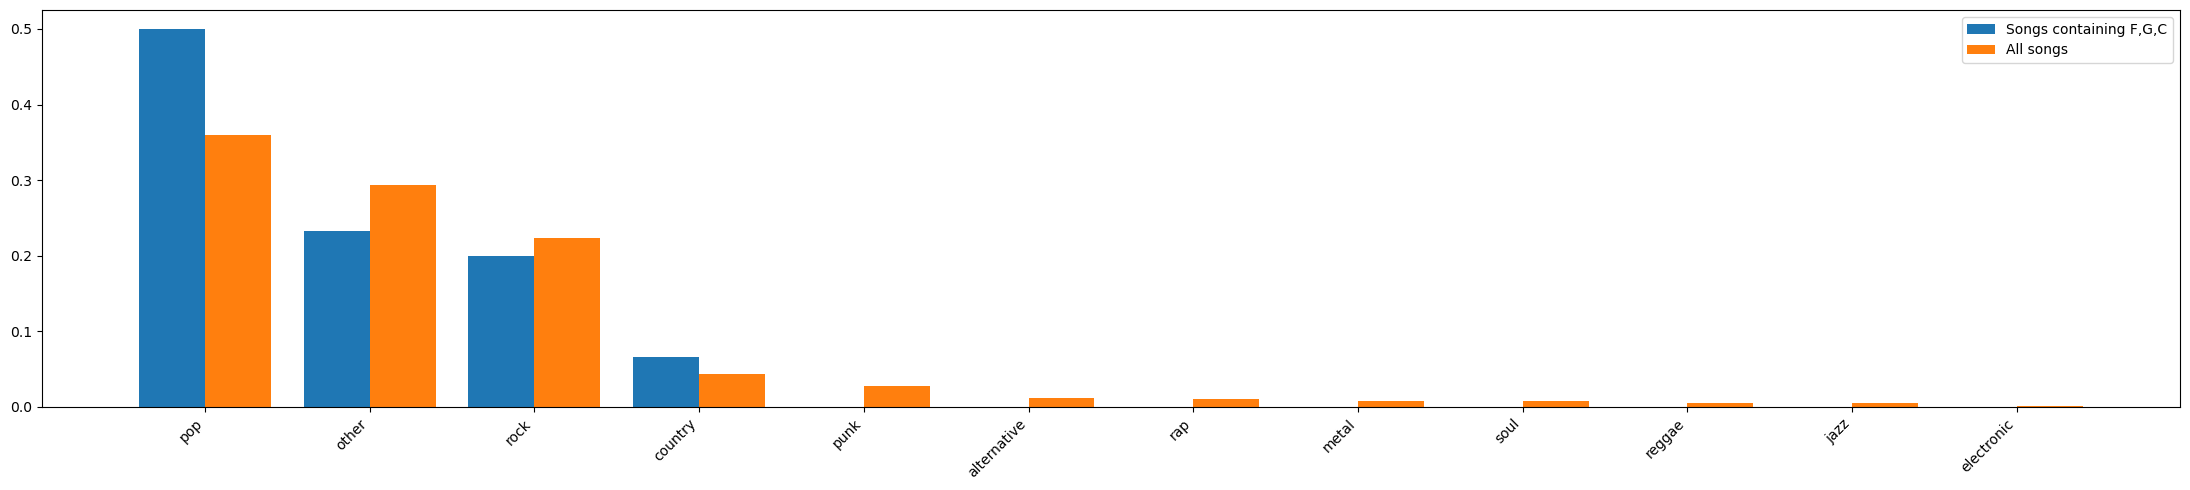

In [18]:
# example of bar chart
sample_size = 100
sample_data = chord_data.sample(sample_size)
genre_bars(data = sample_data,
           n_gram = 'F,G,C',
           column_name = '451')

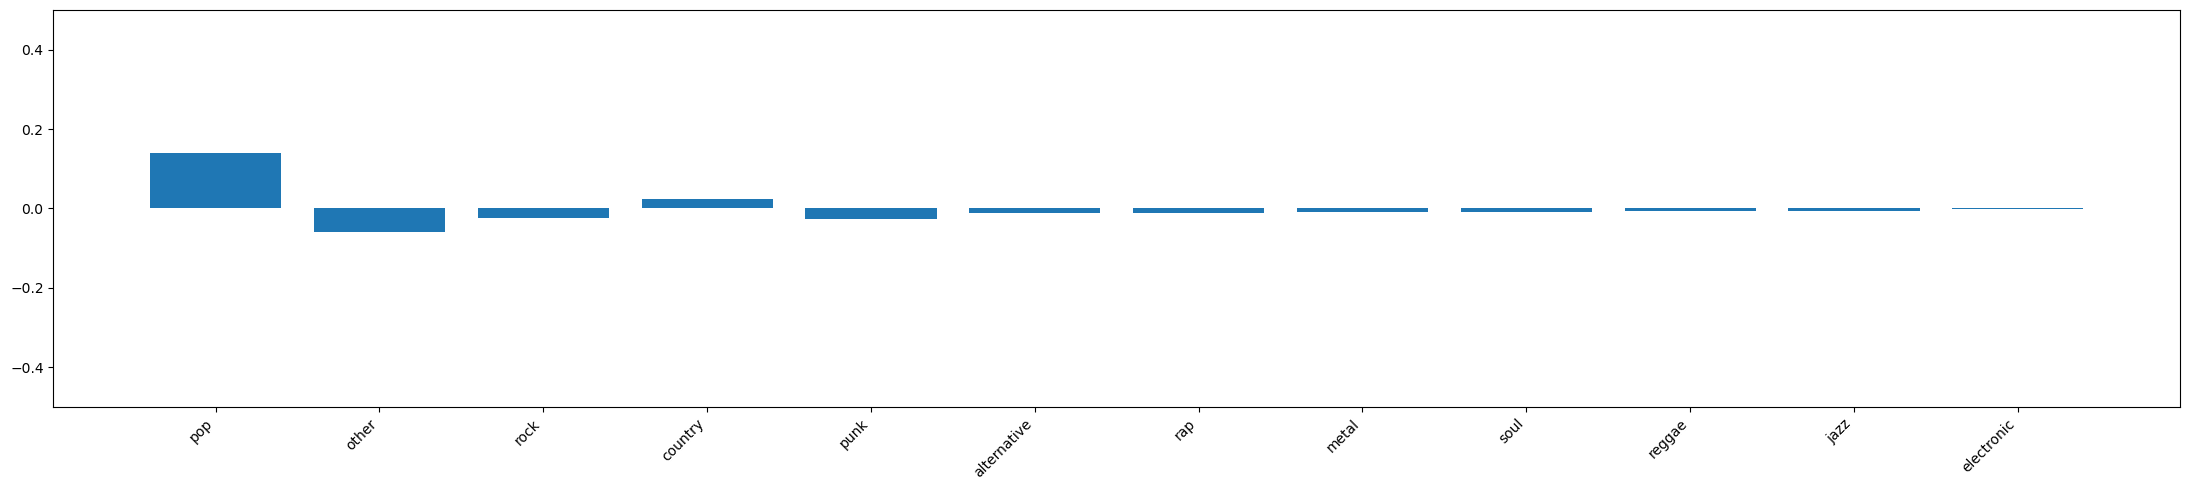

In [19]:
deviation_bars(data = sample_data,
               n_gram = 'F,G,C',
               column_name = '451')

Next objective: make a lot of deviation bar charts for different chord sequences. Maybe I should be more systematic and do some kind of searching for n-grams that have big deviations?

In [21]:
def n_grams(data, n):
    # return a counter object of n-grams, ignoring harmonic equivalence
    chord_n_gram_counter = Counter()
    for song in list(data.chords):
        song_as_list = song.split(',')
        for i in range(len(song_as_list)-n+1):
            n_gram = ','.join(song_as_list[i:i+n])
            chord_n_gram_counter[n_gram] += 1
    return chord_n_gram_counter

In [22]:
def unique_n_grams(chord_n_gram_counter):
    # return a counter object of harmonically unique n-grams
    # this will be a dictionary where keys are (harmonically unique) n-grams, and values are numbers of occurences in the database

    # make a deep copy of the input so we don't modify the original
    chord_n_gram_counter_copy = copy.deepcopy(chord_n_gram_counter)
    
    # we'll build up a counter of uniques
    unique_n_gram_counter = Counter()

    while len(chord_n_gram_counter_copy) > 0:
        n_gram_1 = chord_n_gram_counter_copy.most_common(1)[0][0]
        matrix_1 = string_to_chord_matrix(n_gram_1)
        
        # initialize a list of equivalent n-grams
        equivalent_n_grams = [n_gram_1]
        running_total = chord_n_gram_counter_copy[n_gram_1]

        # delete the current n-gram under consideration so that we don't count it as an equivalent to itself a second time
        del chord_n_gram_counter_copy[n_gram_1]
        
        # go through and find all harmonically equivalent chords to the most common chord left
        for n_gram_2 in chord_n_gram_counter_copy:
            matrix_2 = string_to_chord_matrix(n_gram_2)            
            if is_harmonic_equivalent_matrix(matrix_1, matrix_2):
                equivalent_n_grams.append(n_gram_2)
                running_total = running_total + chord_n_gram_counter_copy[n_gram_2]
    
        # set the value in the new counter to be the accumulated sum
        unique_n_gram_counter[n_gram_1] = running_total

        # go through chord_counts_copy and delete all the chords that were just added to the unique chord counter
        for e in equivalent_n_grams:
            del chord_n_gram_counter_copy[e]

    return unique_n_gram_counter

In [35]:
sample_size = 100
sample_data = chord_data.sample(sample_size)

print("Songs sampled:",sample_size)

# make a raw counter for genres from the entire sample data
baseline_genres = Counter(sample_data.genres)
for g in major_genres:
    if not g in baseline_genres:
        baseline_genres[g] = 0

# make a relative counter for genres (from the entire sample data)
baseline_total = sum(baseline_genres.values())
baseline_genres_relative = {}
for item, count in baseline_genres.items():
    baseline_genres_relative[item] = count / baseline_total

print("Baseline raw genre counts:", baseline_genres)
assert(sum(baseline_genres.values()) == sample_size)
print("Baseline relative genre counts:", baseline_genres_relative)

# initialize the results dictionary, which will eventually be converted into a DataFrame
# This dataframe will have one row for each harmonically unique n-gram (up to a given length) that appears in the sample data
# It will have around 40 columns.
# The first column lists the n_gram
# There are 3 columns for each major genre: raw count (in the sample), relative count (in the sample), and relative deviation from the baseline genre data
# The last three columns are
    # mean absolute relative deviation in that row
    # max absolute relative deviation in that row
    # sample size after filtering by that n_gram
results_dict = {'n_gram': ['baseline']}
for g in major_genres:
    results_dict[g + '_raw'] = [baseline_genres[g]]
    results_dict[g + '_rel'] = [baseline_genres_relative[g]]
    results_dict[g + '_rel_deviation'] = [0.0]
results_dict['mean_abs_deviation'] = [0.0]
results_dict['max_abs_deviation'] = [0.0]
results_dict['filtered_sample_size'] = [sample_size]

n_max = 4
print("\nMax length of n_gram to look at:",n_max)

for n in range(1, n_max+1):
    raw_n_grams = n_grams(sample_data, n)
    my_unique_n_grams = unique_n_grams(raw_n_grams)
    print("Number of unique " + str(n) + "-grams:",len(my_unique_n_grams))
    
    for n_gram in my_unique_n_grams:
        results_dict['n_gram'].append(n_gram)

        # filter the sample data for only songs containing the given n_gram
        one_hot_column = sample_data['chords'].apply(lambda song : contains_n_gram(song, n_gram))
        filtered_data = sample_data[one_hot_column]

        # make absolute and relative counters of genres of the filtered data
        filtered_genres = Counter(filtered_data.genres)
        filtered_total = sum(filtered_genres.values())
        for g in major_genres:
            if not g in filtered_genres:
                filtered_genres[g] = 0
        filtered_genres_relative = {}
        for item, count in filtered_genres.items():
            filtered_genres_relative[item] = count / filtered_total

        # make a relative deviations dictionary
        relative_deviations = {g : filtered_genres_relative[g] - baseline_genres_relative[g] for g in major_genres}
        absolute_relative_deviations = {g : np.abs(relative_deviations[g]) for g in major_genres}

        # loop through the genres and add raw counts, relative counts, and relative deviations to the soon-to-be constructed results dictionary
        for g in major_genres:
            results_dict[g + '_raw'].append(filtered_genres[g])
            results_dict[g + '_rel'].append(filtered_genres_relative[g])
            results_dict[g + '_rel_deviation'].append(relative_deviations[g])

        '''
        if np.max(abs_relative_values == 1):
            print()
            print("n_gram:",n_gram)
            print("Number of songs after filtering for this n_gram:",len(filtered_data.index))
            print("Relative values:",filtered_genres_relative)
            print("Relative deviations:",relative_deviations)
            print("Absolute relative deviations:",{g : np.abs(relative_deviations[g]) for g in major_genres})
            print("Mean absolute relative deviation:",np.mean(list(absolute_relative_deviations.values())))
            print("Maximum absolute relative deviation:",np.max(list(absolute_relative_deviations.values())))
            print()
        '''
        
        results_dict['mean_abs_deviation'].append(np.mean(list(absolute_relative_deviations.values())))
        results_dict['max_abs_deviation'].append(np.max(list(absolute_relative_deviations.values())))
        results_dict['filtered_sample_size'].append(filtered_total)

# convert to a dataframe
results_df = pd.DataFrame(results_dict)

# remove rows where the filtered sample size is below a certain tolerance 
minimum_fraction_of_relevant_sample = 0.1 # play around with this parameter
results_df = results_df[results_df.filtered_sample_size >= sample_size * minimum_fraction_of_relevant_sample]

print('\nMinimum fraction of sample to include:',minimum_fraction_of_relevant_sample)
print('Number of n_grams meeting the minimum filtered sample size criteria:',len(results_df.index))

# filter out for n_grams with high deviation
max_deviation = results_df['max_abs_deviation'].max()
tolerance = max_deviation * 0.05
high_deviation_n_grams = results_df[results_df['max_abs_deviation'] > max_deviation - tolerance]
relative_deviation_columns = [g + '_rel_deviation' for g in major_genres]
columns_of_interest = ['n_gram'] + [g + '_rel_deviation' for g in major_genres] + ['mean_abs_deviation','max_abs_deviation','filtered_sample_size']
high_deviation_n_grams = high_deviation_n_grams[columns_of_interest]

print('\nMaximum deviation:',max_deviation)
print('Error tolerance:',tolerance)
print('Number of n-grams with maximum deviation within this error tolerance of the largest maximum deviation:',len(high_deviation_n_grams.index))

high_deviation_n_grams

Songs sampled: 100
Baseline raw genre counts: Counter({'pop': 41, 'other': 25, 'rock': 21, 'country': 5, 'punk': 2, 'rap': 2, 'electronic': 1, 'reggae': 1, 'jazz': 1, 'soul': 1, 'alternative': 0, 'metal': 0})
Baseline relative genre counts: {'pop': 0.41, 'other': 0.25, 'rock': 0.21, 'electronic': 0.01, 'reggae': 0.01, 'jazz': 0.01, 'country': 0.05, 'punk': 0.02, 'rap': 0.02, 'soul': 0.01, 'alternative': 0.0, 'metal': 0.0}

Max length of n_gram to look at: 4
Number of unique 1-grams: 17
Number of unique 2-grams: 214
Number of unique 3-grams: 730
Number of unique 4-grams: 1447


KeyboardInterrupt: 

In [ ]:
# make some bar charts for the n_grams with high deviation
num_rows = len(high_deviation_n_grams.index)

# iterate over rows of the high_deviation dataframe, make a bar chart for each
for i in range(num_rows):
    row_i = high_deviation_n_grams.iloc[i]
    height_data = [row_i[g + '_rel_deviation'] for g in major_genres]
    my_x = np.arange(len(major_genres))
    plt.figure(figsize = (20, 4))
    plt.bar(x = my_x,
            height = height_data)
    plt.xticks(my_x, major_genres, rotation = 45, ha = 'right')
    plt.ylim(-1,1)
    
    plt.title('Deviations from baseline genre distribution for songs containing ' + row_i['n_gram'] + ', based on a filtered set of ' + str(row_i['filtered_sample_size']) + ' songs')
    plt.show()